# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

0_label5.png: Pred: 1, Label: 5
1_label3.png: Pred: 1, Label: 3
2_label3.png: Pred: 1, Label: 3
3_label7.png: Pred: 3, Label: 7
4_label2.png: Pred: 6, Label: 2


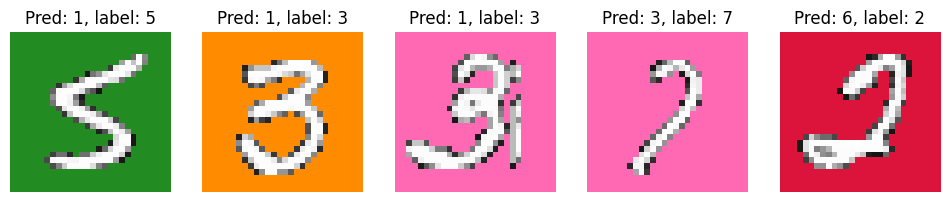

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

In [5]:
from captum.attr import IntegratedGradients
import numpy as np
import cv2
import os
import random
import io
import contextlib
import torch.nn.functional as F

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def remarcar_contornos_internos(ruta_imagen):
    imagen = cv2.imread(ruta_imagen)
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

    _, binaria = cv2.threshold(gris, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contornos, jerarquia = cv2.findContours(binaria, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    if jerarquia is not None:
        jerarquia = jerarquia[0]  # acceder a la jerarquía real

        for i, contorno in enumerate(contornos):
            
            if jerarquia[i][3] != -1:
                cv2.drawContours(imagen, contornos, i, (0, 0, 0), 1)

    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)

    imagen_pil = Image.fromarray(imagen_rgb)
    return imagen_pil

edited_dir = challenge_dir / "edited"

idx = [1,3,4]

for img_path in image_files:
    save_path = edited_dir / img_path.name
    if img_path not in [image_files[i] for i in idx]:
        img_cont = cv2.imread(img_path)
        img_cont = cv2.cvtColor(img_cont, cv2.COLOR_BGR2RGB)
        img_cont = Image.fromarray(img_cont)
        img_cont.save(save_path)
        continue
    img_cont = remarcar_contornos_internos(img_path)
    img_cont.save(save_path)
    

In [ ]:
def modify_image(img_pil, saliency_diff, max_change_ratio=0.4):
    img_np = np.array(img_pil).astype(np.float32) / 255.0
    importance = np.abs(saliency_diff)

    threshold = np.quantile(importance, 1 - max_change_ratio + 0.01)

    if threshold != 0:
        mask = importance >= threshold

        img_mod = img_np.copy()

        lighter_mask = (saliency_diff < 0) & mask
        darker_mask = (~lighter_mask) & mask

        img_mod[lighter_mask] = 0.95
        img_mod[darker_mask] = 0.2

        # Limitar a rango válido
        img_mod = np.clip(img_mod, 0, 1)

        img_mod_pil = Image.fromarray((img_mod * 255).astype(np.uint8))
        return img_mod_pil
    else:
        return img_pil

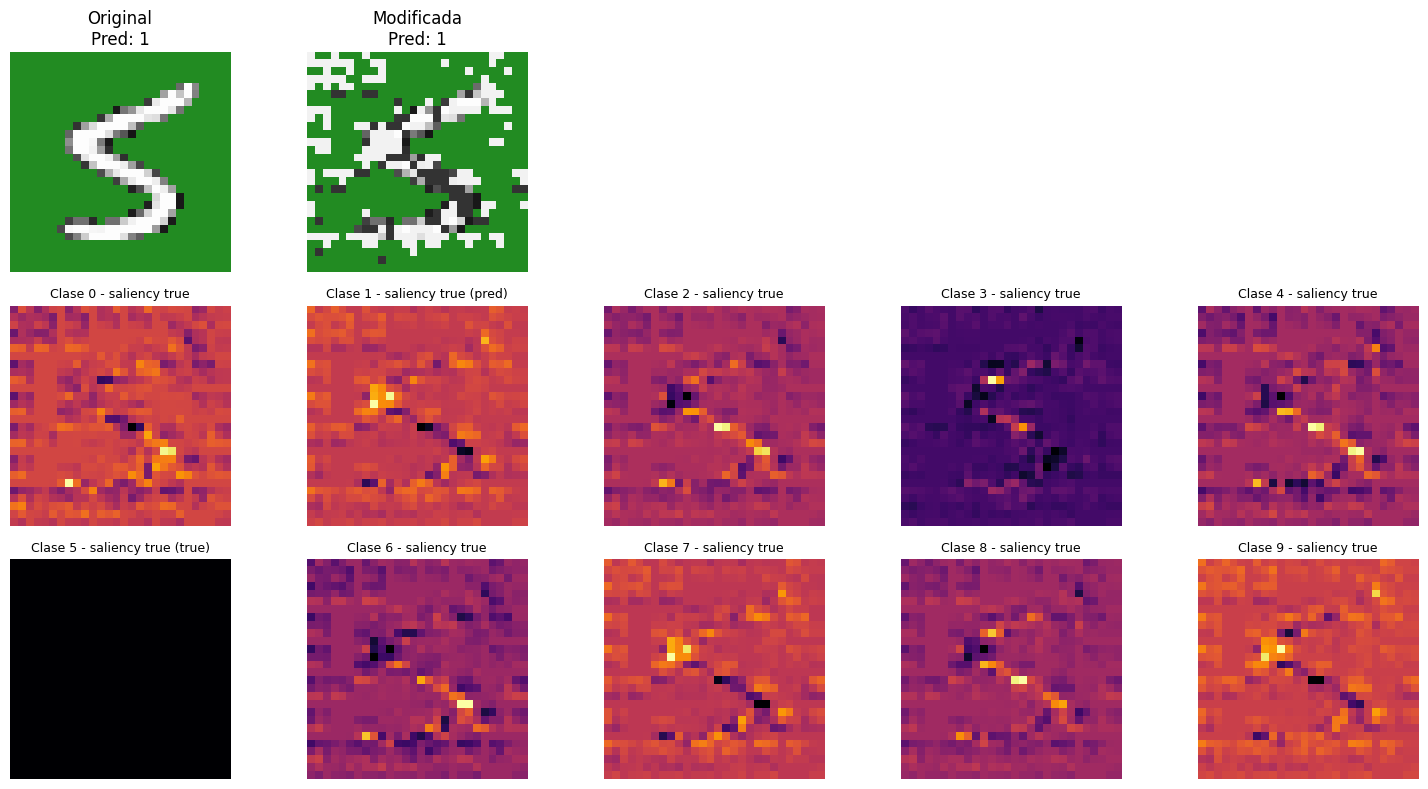

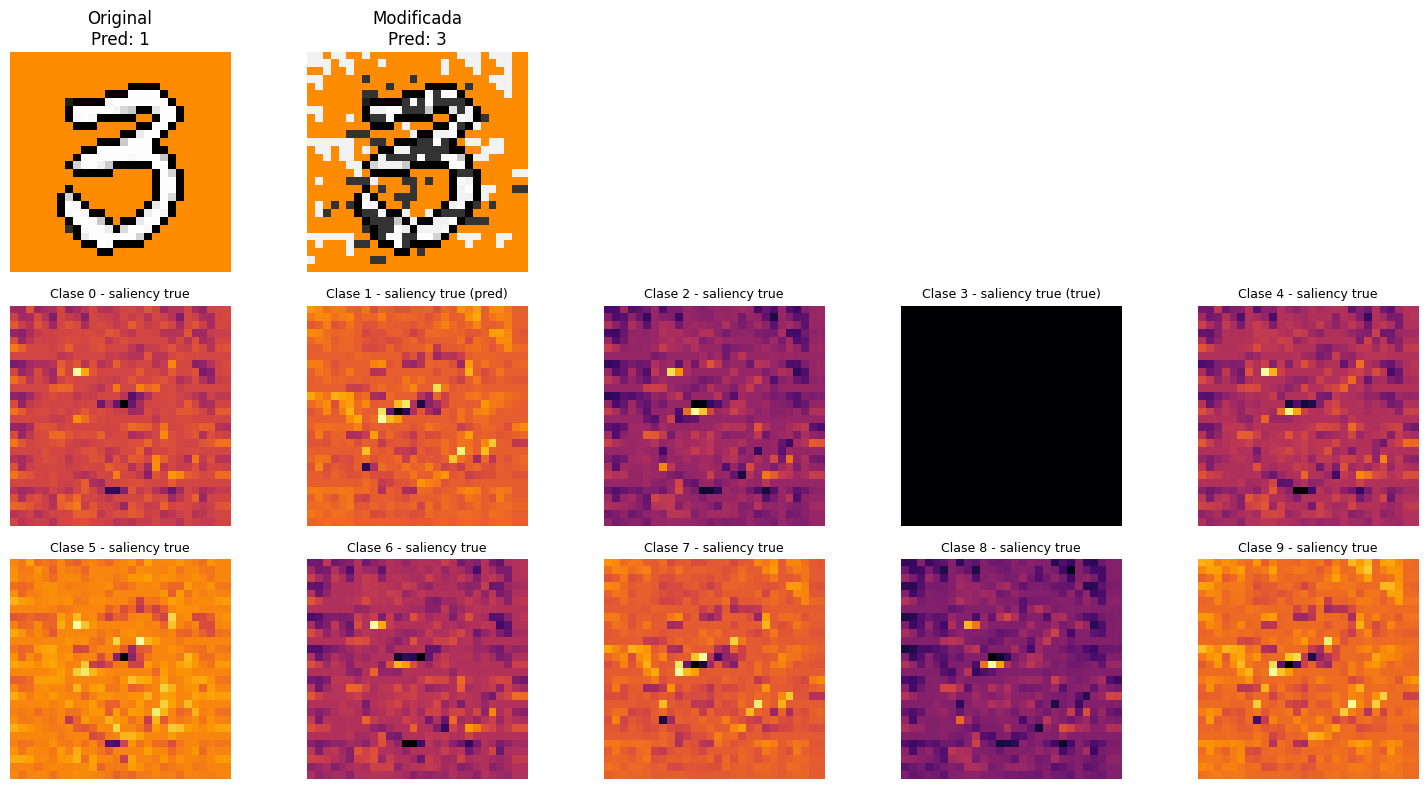

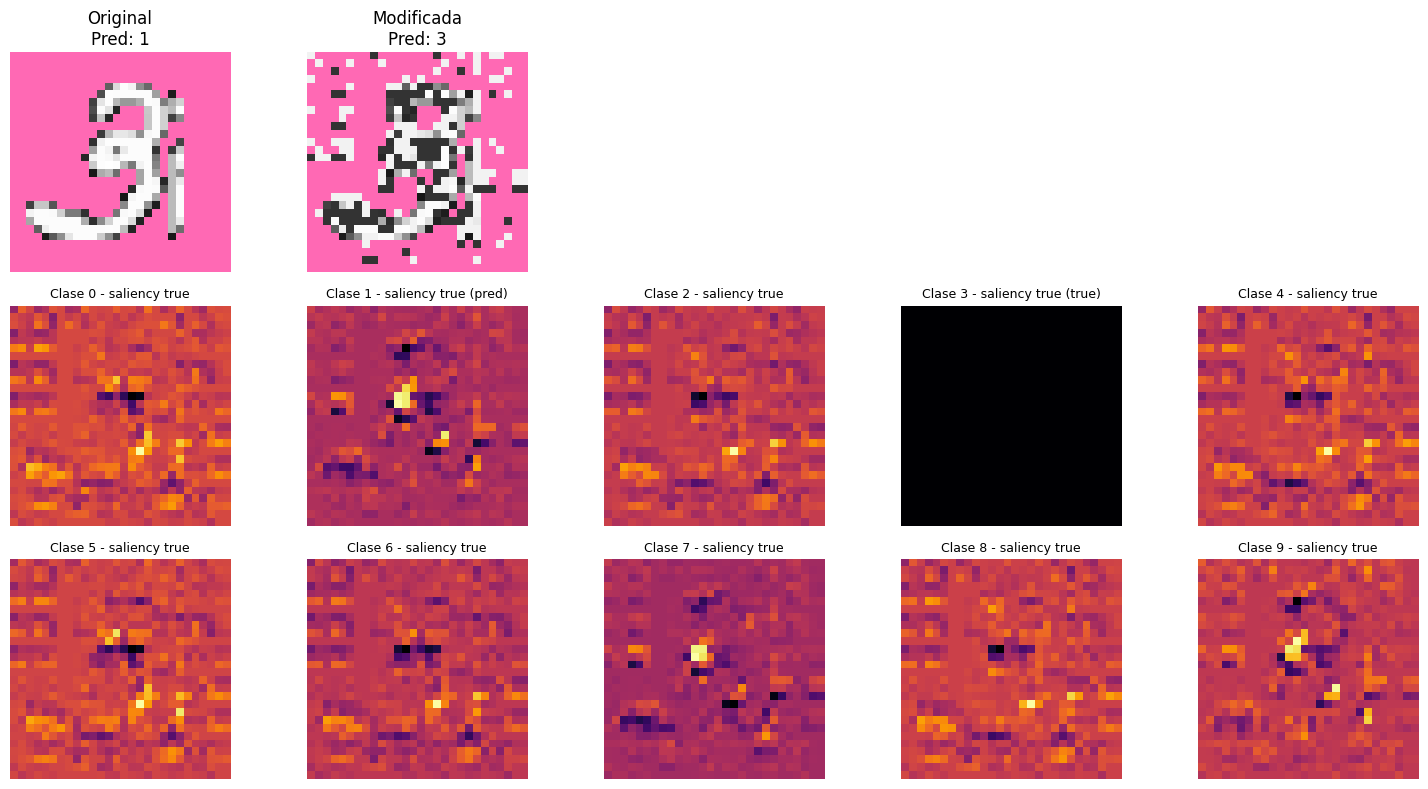

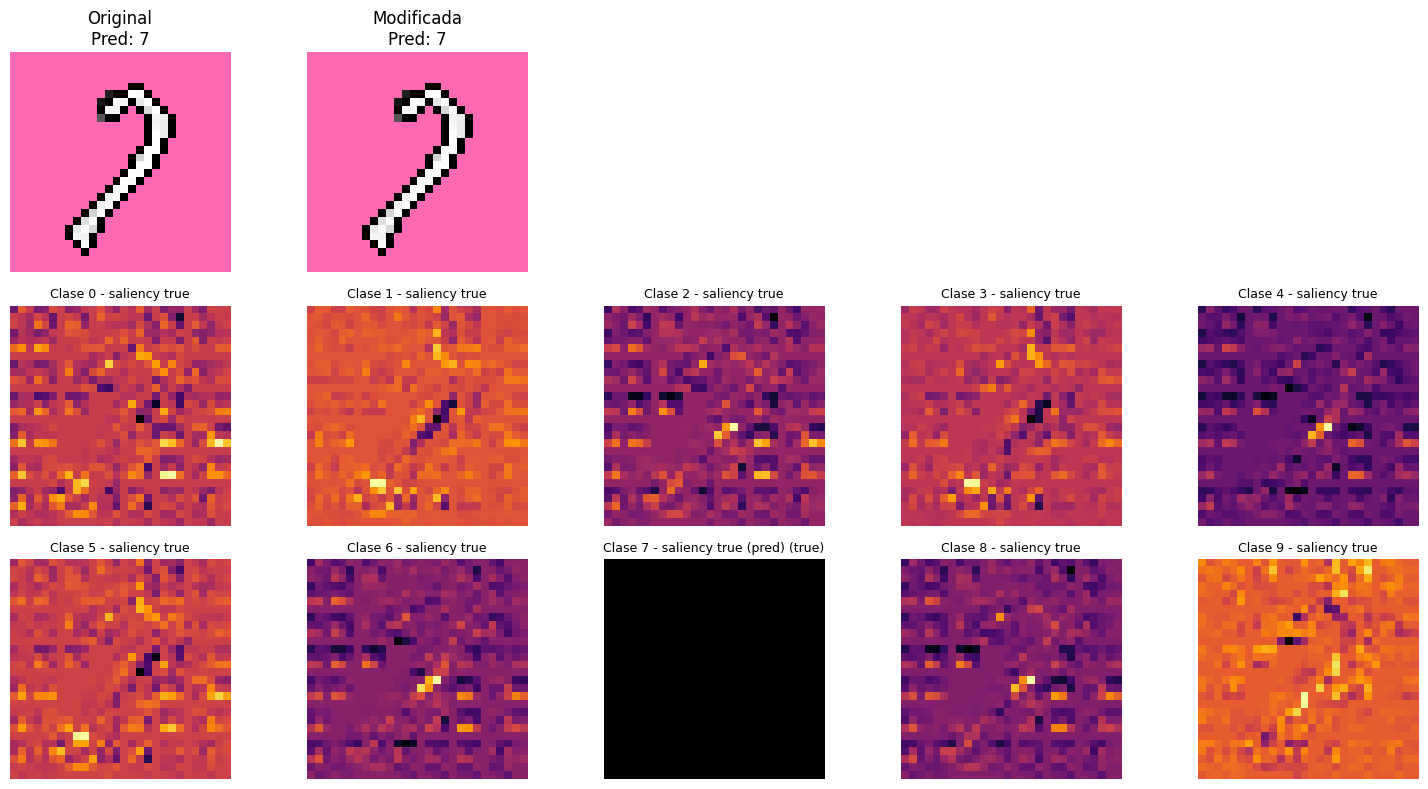

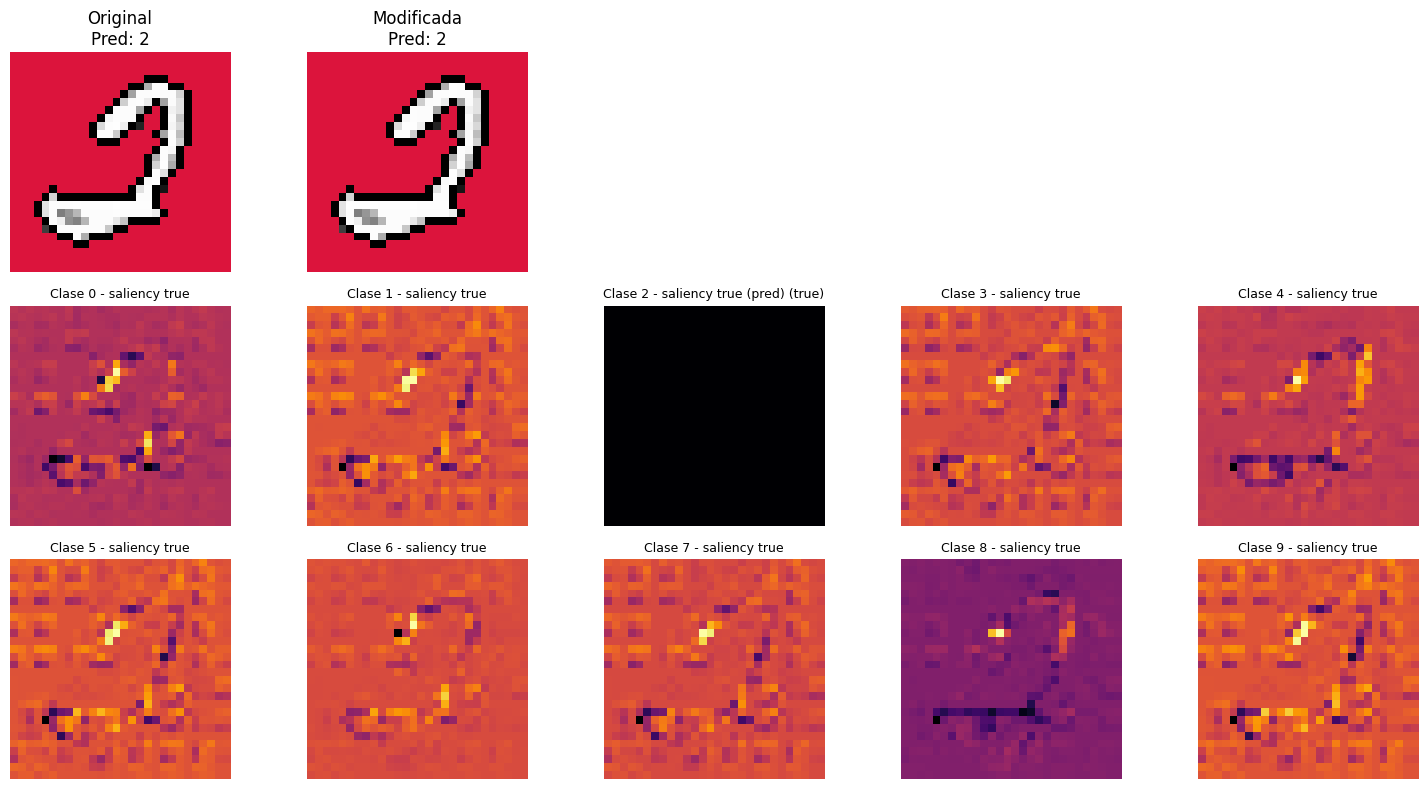

In [8]:
ig = IntegratedGradients(model)

edited_dir = challenge_dir / "edited"
image_edited = list(edited_dir.glob('*.png'))

for img_path in image_edited:

    label_true = int(img_path.stem.split('_')[1][-1])
    
    img = Image.open(img_path).convert('RGB')
    x = to_tensor(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(x)
        pred = output.argmax(dim=1).item()

    attrs_all = []
    for i in range(10):
        attr_i = ig.attribute(x, target=i, n_steps=32)
        attr_i = attr_i.sum(dim=1).squeeze().cpu().detach().numpy()
        attrs_all.append(attr_i)

    attr_pred = attrs_all[pred]
    attr_true = attrs_all[label_true]

    diff = attr_true - attr_pred

    img_mod = modify_image(img, diff, max_change_ratio=0.27)
    x_mod = to_tensor(img_mod).unsqueeze(0).to(device)

    with torch.no_grad():
        output_mod = model(x_mod)
        pred_mod = output_mod.argmax(dim=1).item()

    # Visualización
    save_path = edited_dir / img_path.name
    img_mod.save(save_path)

    # Imagen original
    fig = plt.figure(figsize=(15, 8))

    # Imagen original
    plt.subplot(3, 5, 1)
    plt.imshow(img)
    plt.title(f'Original\nPred: {pred}')
    plt.axis('off')

    # Imagen modificada
    plt.subplot(3, 5, 2)
    plt.imshow(img_mod)
    plt.title(f'Modificada\nPred: {pred_mod}')
    plt.axis('off')

    # Mostrar saliency maps para las 10 clases
    for i in range(10):
        plt.subplot(3, 5, i + 6)
        plt.imshow(attrs_all[i]- attr_true, cmap='inferno')
        title = f'Clase {i} - saliency true'
        if i == pred:
            title += ' (pred)'
        if i == label_true:
            title += ' (true)'
        plt.title(title, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
MNIST_LABELS = (
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
)


def _add_information(
    img: torch.Tensor, perturbed_img: torch.Tensor, label: int, model: nn.Module
) -> str:
    """
    Adds information to the image corresponding to the "before and after" of the
    perturbation.

    Parameters
    ----------
    img           : Original image. Dimensions: [channels, height, width].
    perturbed_img : Perturbed image. Dimensions: [channels, height, width].
    label         : Real label of the image.
    model         : Model used.

    Returns
    -------
    String with the included information.
    """

    real_class = MNIST_LABELS[label]
    output = io.StringIO()

    with contextlib.redirect_stdout(output):
        print(f"True Label: {real_class}")
        with torch.no_grad():
            y_pred = model(img.unsqueeze(0)).squeeze()
            y_pred_perturbed = model(perturbed_img.unsqueeze(0)).squeeze()

        original_prediction = MNIST_LABELS[torch.argmax(y_pred)]
        real_prob = y_pred[label].item()
        original_prob = torch.max(y_pred).item()
        print(f"\nOriginal prediction: {original_prediction}")
        print(
            f"Log-Probability for real label ({real_class}):"
            f"{real_prob:.2f}"
        )
        print(
            f"Log-Probability for prediction ({original_prediction}):"
            f"{original_prob:.2f}"
        )

        original_perturbed_prediction = MNIST_LABELS[torch.argmax(y_pred_perturbed)]
        real_perturbed_prob = y_pred_perturbed[label].item()
        original_perturbed_prob = torch.max(y_pred_perturbed).item()
        print(f"\nPerturbed prediction: {original_perturbed_prediction}")
        print(
            f"Log-Probability for real label ({real_class}):"
            f"{real_perturbed_prob:.2f}"
        )
        print(
            f"Log-Probability for perturbed prediction ({original_perturbed_prediction}):"
            f"{original_perturbed_prob:.2f}"
        )

    print(f"\nPerturbed logs: {model(perturbed_img.unsqueeze(0))}")
    return output.getvalue()


def visualize_perturbations(
    perturbed_img: torch.Tensor,
    img: torch.Tensor,
    label: int,
    model: nn.Module,
    title: str | None = None,
) -> None:
    """
    Saves a figure with the "before and after" of the perturbation.

    Parameters
    ----------
    perturbed_img : Perturbed image. Dimensions: [channels, height, width].
    img           : Original image. Dimensions: [channels, height, width].
    label         : Real label of the image.
    model         : Model used.
    title         : Title of the figure.
    """

    fig, axs = plt.subplots(1, 2, figsize=(14, 8))
    fig.suptitle(
        _add_information(img, perturbed_img, label, model),
        ha="center",
        fontsize=14,
        fontfamily="monospace",
        wrap=True,
        y=1.05,
    )

    axs[0].imshow(
        np.transpose(img.cpu().numpy(), (1, 2, 0)), interpolation="nearest"
    ) 
    axs[0].set_title("Original Image") 
    axs[1].imshow(
        np.transpose(perturbed_img.cpu().numpy(), (1, 2, 0)),
        interpolation="nearest",
    ) 
    axs[1].set_title("Perturbed Image")  #
    plt.subplots_adjust(top=0.8)

    if title is None:
        title = f"adversarial_attack_{MNIST_LABELS[label]}"

    # Convert tensor to numpy
    img_np = perturbed_img.cpu().numpy()

    # Clip to [0,1] if floating-point
    img_np = np.clip(img_np, 0, 1)
    # If single channel
    if img_np.shape[0] == 1:
        img_np = img_np.squeeze(0)  # H x W
    else:
        img_np = img_np.transpose(1, 2, 0)  # H,W,C

    # Save
    os.makedirs("../data/MNIST//challenge/edited", exist_ok=True)
    plt.imsave(f"../data/MNIST/challenge/edited/{title}.png", img_np)

def set_seed(seed: int) -> None:
    """
    This function sets a seed and ensure a deterministic behavior.

    Parameters
    ----------
    seed : Seed number to fix radomness.
    """

    # set seed in numpy and random
    np.random.seed(seed)
    random.seed(seed)

    # set seed and deterministic algorithms for torch
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

    # Ensure all operations are deterministic on GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # for deterministic behavior on cuda >= 10.2
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [10]:
class NPixelRandomSearch:
    """
    Prueba n combinaciones aleatorias de d píxeles cambiados (flip)
    y devuelve la primera combinación que haga que el modelo prediga true_label.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        img: torch.Tensor,
        true_label: int,
        d: int = 1,
        saliency_map: torch.Tensor | None = None,
        saliency_threshold: float = 0.1,
        n_trials: int = 1000
    ):
        self.model = model
        self.img = img  # [B, C, H, W]
        self.true_label = true_label
        self.d = d
        self.n_trials = n_trials

        self.valid_coords = self._set_mask(saliency_map, saliency_threshold)

        if self.valid_coords is None:
            _, _, H, W = img.shape
            self.valid_coords = torch.tensor([(i, j) for i in range(H) for j in range(W)])

    def _set_mask(self, saliency_map: torch.Tensor | None, threshold: float):
        if saliency_map is None:
            return None
        saliency_map = saliency_map.squeeze(0)  # [H, W]
        mask = (torch.abs(saliency_map) > threshold)
        return torch.nonzero(mask, as_tuple=False)  # [num_valid, 2]

    def _apply_flip_pixels(self, coords: list[tuple[int, int]], img: torch.Tensor):
        """
        Cambia los píxeles indicados por coords en la imagen (flip 1 -> 0, 0 -> 1).
        """
        p_img = img.clone()
        for (x, y) in coords:
            p_img[:, :, x, y] = 1 - p_img[:, :, x, y]
        return p_img

    def find_perturbation(self):
        """
        Prueba n_trials combinaciones aleatorias de d píxeles flip para encontrar
        la que haga que el modelo prediga true_label.
        """
        coords_list = self.valid_coords.tolist()
        tested = 0

        for _ in range(self.n_trials):
            comb = random.sample(coords_list, self.d)
            tested += 1

            perturbed_img = self._apply_flip_pixels(comb, self.img)

            with torch.no_grad():
                logits = self.model(perturbed_img)
                pred = torch.argmax(logits, dim=1).item()

            if pred == self.true_label:
                print(f"Encontrada combinación ganadora tras {tested} pruebas.")
                return perturbed_img, comb

        print(f"No se encontró combinación en {self.n_trials} intentos.")
        return None, None

In [11]:
image_tensors = [to_tensor(Image.open(image_file)).unsqueeze(0).to(device) for image_file in image_files]

Encontrada combinación ganadora tras 207 pruebas.

Perturbed logs: tensor([[-1.9086, -0.3030, -1.8232,  0.0223, -1.2782,  0.2906, -0.6993, -0.1480,
         -0.9215, -0.5270]], device='cuda:0', grad_fn=<AddmmBackward0>)


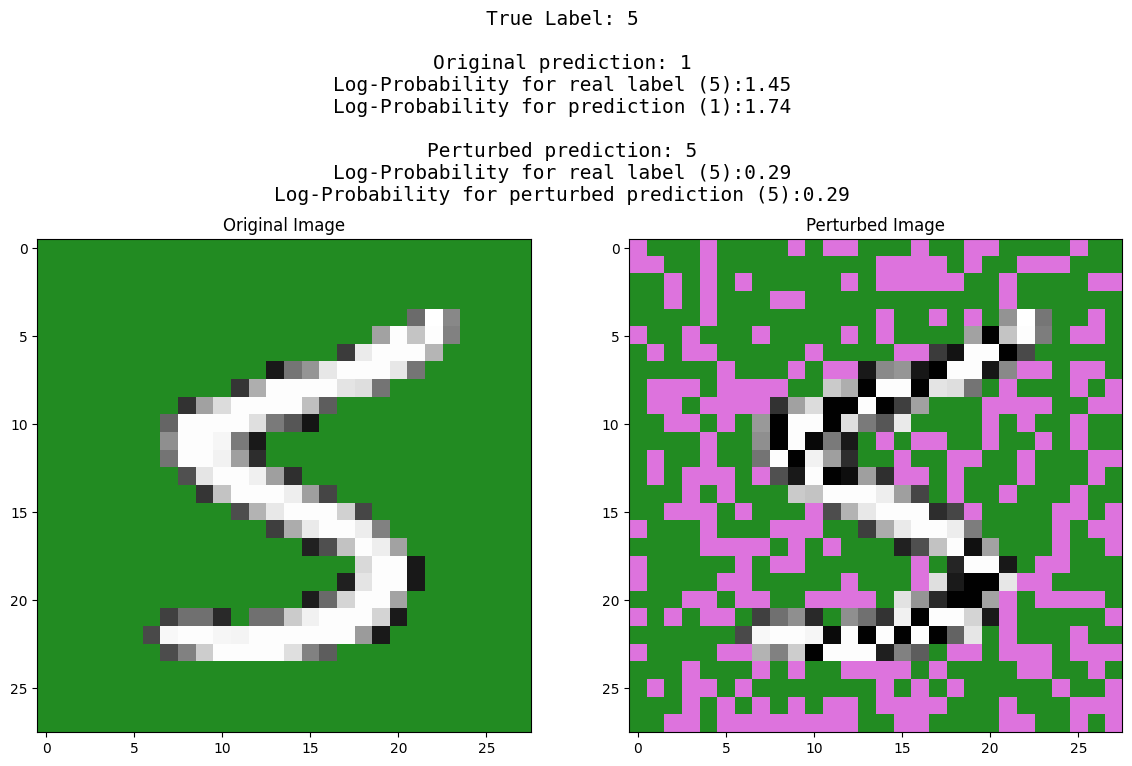

In [12]:
for i, true_label, img_tensor in zip(range(0, 1), [5], image_tensors[0:1]):
    nprs = NPixelRandomSearch(model, img_tensor, true_label, n_trials=10000, d=300)
    p_image, perturbations = nprs.find_perturbation()
    visualize_perturbations(p_image.squeeze(), img_tensor.squeeze(), true_label, model, title=f"{i}_label{true_label}")

---
## Check if you have passed the challenge 

In [13]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [14]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')

Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 38.27%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 38.01%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 26.02%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 6.25%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 9.82%
